# Tutorial: Time binning

This tutorial will teach you how to time bin variables as an essential processing step.

We will use the loaded variables from the cdf file for the tutorial.

In [9]:
from datetime import datetime, timezone

from astropy import units as u

import el_paso as ep

extraction_infos = [
    ep.ExtractionInfo(
        result_key="Epoch",
        name_or_column="Epoch_Ele",
        unit=u.tt2000,
    ),
    ep.ExtractionInfo(
        result_key="FEDU",
        name_or_column="FEDU",
        unit=(u.cm**2 * u.s * u.sr * u.keV) ** (-1),
    ),
    ep.ExtractionInfo(
        result_key="xGEO",
        name_or_column="Position_Ele",
        unit=u.km,
    ),
]

start_time = datetime(2017, 7, 30, tzinfo=timezone.utc)
end_time = datetime(2017, 8, 1, 23, 59,59, tzinfo=timezone.utc)

file_name_stem = "rbspa_rel04_ect-hope-pa-l3_YYYYMMDD_.{6}.cdf"

ep.download(start_time, end_time,
             save_path=".",
             download_url="https://spdf.gsfc.nasa.gov/pub/data/rbsp/rbspa/l3/ect/hope/pitchangle/rel04/YYYY/",
             file_name_stem=file_name_stem,
             file_cadence="daily",
             method="request",
             skip_existing=True)

variables = ep.extract_variables_from_files(start_time, end_time, "daily",
                                             data_path=".", file_name_stem=file_name_stem,
                                             extraction_infos=extraction_infos)
variables

File already exists, skipping download: rbspa_rel04_ect-hope-pa-l3_20170730_v7.3.0.cdf
File already exists, skipping download: rbspa_rel04_ect-hope-pa-l3_20170731_v7.4.0.cdf
File already exists, skipping download: rbspa_rel04_ect-hope-pa-l3_20170801_v7.3.0.cdf
Extracting variables ...
Concatenating data for Epoch_Ele ...
Concatenating data for FEDU ...
Concatenating data for Position_Ele ...
Concatenating data for Epoch_Ele ...
Concatenating data for FEDU ...
Concatenating data for Position_Ele ...
		Finished in 0.149 seconds


{'Epoch': Variable holding (12474,) data points with metadata: VariableMetadata(unit=Unit("tt2000"), original_cadence_seconds=0, source_files=['rbspa_rel04_ect-hope-pa-l3_20170730_v7.3.0.cdf', 'rbspa_rel04_ect-hope-pa-l3_20170731_v7.4.0.cdf', 'rbspa_rel04_ect-hope-pa-l3_20170801_v7.3.0.cdf'], description='', processing_notes='', standard_name=''),
 'FEDU': Variable holding (12474, 11, 72) data points with metadata: VariableMetadata(unit=Unit("1 / (keV s sr cm2)"), original_cadence_seconds=0, source_files=['rbspa_rel04_ect-hope-pa-l3_20170730_v7.3.0.cdf', 'rbspa_rel04_ect-hope-pa-l3_20170731_v7.4.0.cdf', 'rbspa_rel04_ect-hope-pa-l3_20170801_v7.3.0.cdf'], description='', processing_notes='', standard_name=''),
 'xGEO': Variable holding (12474, 3) data points with metadata: VariableMetadata(unit=Unit("km"), original_cadence_seconds=0, source_files=['rbspa_rel04_ect-hope-pa-l3_20170730_v7.3.0.cdf', 'rbspa_rel04_ect-hope-pa-l3_20170731_v7.4.0.cdf', 'rbspa_rel04_ect-hope-pa-l3_20170801_v7.3.

Time binning is one essential processing step, you probably want to use for most satellite missions. The function is part of the *processing* module, which holds functions you can use for processing your variables. The function *bin_by_time* changes the variables in place to reduce memory, because before time binning, data sizes can be quite big. A new time variable is created with the same cadence as provided as an input to the function.

For every variable, which should be time-binned, you have to provide a corresponding time-bin-method. This dictionary is used as input in the time binning function.
If you want to change the start- and end-time of the binning, you should truncate the variables first. This can be done by the *truncate()* method of variable class.

Time binning ...
		Finished in 0.039 seconds


Text(0, 0.5, 'log10 Flux')

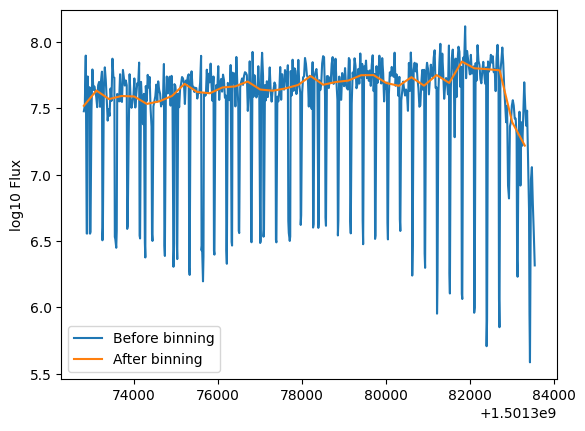

In [10]:
from datetime import timedelta

import numpy as np
from matplotlib import pyplot as plt

variables["xGEO"].truncate(variables["Epoch"], start_time, start_time+timedelta(hours=3))
variables["FEDU"].truncate(variables["Epoch"], start_time, start_time+timedelta(hours=3))
variables["Epoch"].truncate(variables["Epoch"], start_time, start_time+timedelta(hours=3))

plt.plot(variables["Epoch"].get_data(u.posixtime), np.log10(variables["FEDU"].get_data()[:,5,10]), label="Before binning")

time_bin_methods = {
    "xGEO": ep.TimeBinMethod.NanMean,
    "FEDU": ep.TimeBinMethod.NanMedian,
}

binned_time_variable = ep.processing.bin_by_time(variables["Epoch"], variables=variables,
                                                 time_bin_method_dict=time_bin_methods,
                                                 time_binning_cadence=timedelta(minutes=5))

plt.plot(binned_time_variable.get_data(u.posixtime), np.log10(variables["FEDU"].get_data()[:,5,10]), label="After binning")
plt.legend()
plt.ylabel("log10 Flux")
